In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import shap
tf.compat.v1.experimental.output_all_intermediates(True)

In [2]:
tf.random.set_seed(36)

## Dataset

In [3]:
BASE_DIR_PATH = '../Datasets'
DATASET_FILE = os.path.join(BASE_DIR_PATH, '2016_2017_sto_nino_and_montalban.csv')

In [4]:
df = pd.read_csv(DATASET_FILE)
df

,Unnamed: 0,datetime,month,day,hour,t,Station,x,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel,Discharge,Cross_Section,Velocity,fric_coeff,slope
0,0,2016-01-01 00:00:00,1,1,0,0.0,Montalban,0,0,1,2,0,0,21.03,14.842428,630.90,0.023526,0.035,0.002000
1,1,2016-01-01 00:00:00,1,1,0,0.0,Sto_Nino,14420,0,1,2,0,0,12.18,21.033407,803.88,0.026165,0.033,0.000667
2,2,2016-01-01 01:00:00,1,1,1,3600.0,Montalban,0,0,1,1,1,0,21.03,14.842428,630.90,0.023526,0.035,0.002000
3,3,2016-01-01 01:00:00,1,1,1,3600.0,Sto_Nino,14420,0,1,1,1,0,12.19,21.280072,804.54,0.026450,0.033,0.000667
4,4,2016-01-01 02:00:00,1,1,2,7200.0,Montalban,0,1,1,1,0,1,21.03,14.842428,630.90,0.023526,0.035,0.002000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,35035,2017-12-31 21:00:00,12,31,21,63147600.0,Sto_Nino,14420,0,0,0,0,0,12.44,28.244204,821.04,0.034401,0.033,0.000667
35036,35036,2017-12-31 22:00:00,12,31,22,63151200.0,Montalban,0,0,0,0,0,0,21.18,17.224575,635.40,0.027108,0.035,0.002000
35037,35037,2017-12-31 22:00:00,12,31,22,63151200.0,Sto_Nino,14420,0,0,0,0,0,12.44,28.244204,821.04,0.034401,0.033,0.000667
35038,35038,2017-12-31 23:00:00,12,31,23,63154800.0,Montalban,0,0,0,0,0,0,21.18,17.224575,635.40,0.027108,0.035,0.002000


In [5]:
df = df[['month', 'day', 'hour', 'Station', 'Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'Waterlevel']]
df

,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
0,1,1,0,Montalban,0,1,2,0,0,21.03
1,1,1,0,Sto_Nino,0,1,2,0,0,12.18
2,1,1,1,Montalban,0,1,1,1,0,21.03
3,1,1,1,Sto_Nino,0,1,1,1,0,12.19
4,1,1,2,Montalban,1,1,1,0,1,21.03
...,...,...,...,...,...,...,...,...,...,...
35035,12,31,21,Sto_Nino,0,0,0,0,0,12.44
35036,12,31,22,Montalban,0,0,0,0,0,21.18
35037,12,31,22,Sto_Nino,0,0,0,0,0,12.44
35038,12,31,23,Montalban,0,0,0,0,0,21.18


In [6]:
df['Station'] = [1 if x == 'Sto_Nino' else 0 for x in df['Station']]
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
0,1,1,0,0,0,1,2,0,0,21.03
1,1,1,0,1,0,1,2,0,0,12.18
2,1,1,1,0,0,1,1,1,0,21.03
3,1,1,1,1,0,1,1,1,0,12.19
4,1,1,2,0,1,1,1,0,1,21.03
...,...,...,...,...,...,...,...,...,...,...
35035,12,31,21,1,0,0,0,0,0,12.44
35036,12,31,22,0,0,0,0,0,0,21.18
35037,12,31,22,1,0,0,0,0,0,12.44
35038,12,31,23,0,0,0,0,0,0,21.18


## Window Generator

In [7]:
sto_nino_df = df[df['Station'] == 1]
sto_nino_df

,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
1,1,1,0,1,0,1,2,0,0,12.18
3,1,1,1,1,0,1,1,1,0,12.19
5,1,1,2,1,1,1,1,0,1,12.19
7,1,1,3,1,0,0,0,1,0,12.20
9,1,1,4,1,1,1,1,0,0,12.20
...,...,...,...,...,...,...,...,...,...,...
35031,12,31,19,1,0,0,0,0,0,12.44
35033,12,31,20,1,0,0,0,0,0,12.44
35035,12,31,21,1,0,0,0,0,0,12.44
35037,12,31,22,1,0,0,0,0,0,12.44


In [8]:
n = len(sto_nino_df)

In [9]:
sto_nino_train_df = sto_nino_df[0:int(n*0.5)]
sto_nino_val_df = sto_nino_df[int(n*0.5):int(n*0.75)]
sto_nino_test_df = sto_nino_df[int(n*0.75):]

In [10]:
sto_nino_train_df.shape

(8760, 10)

In [11]:
sto_nino_val_df.shape

(4380, 10)

In [12]:
sto_nino_test_df.shape

(4380, 10)

In [13]:
montalban_df = df[df['Station'] == 0]
montalban_df

,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
0,1,1,0,0,0,1,2,0,0,21.03
2,1,1,1,0,0,1,1,1,0,21.03
4,1,1,2,0,1,1,1,0,1,21.03
6,1,1,3,0,0,0,0,1,0,21.03
8,1,1,4,0,1,1,1,0,0,21.03
...,...,...,...,...,...,...,...,...,...,...
35030,12,31,19,0,0,0,0,0,0,21.18
35032,12,31,20,0,0,0,0,0,0,21.18
35034,12,31,21,0,0,0,0,0,0,21.18
35036,12,31,22,0,0,0,0,0,0,21.18


In [14]:
montalban_train_df = montalban_df[0:int(n*0.5)]
montalban_val_df = montalban_df[int(n*0.5):int(n*0.75)]
montalban_test_df = montalban_df[int(n*0.75):]

In [15]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    # Creating tf datasets for more convenient use and integration into model in the future
    def make_dataset(self, data, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    # properties to access them as tf datasets
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df, False)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

### possible hyperparam: # of consecutive hours taken together

In [16]:
CONSECUTIVE_HOURS = 6

In [17]:
sto_nino_window = WindowGenerator(
        input_width=CONSECUTIVE_HOURS, label_width=1, shift=1,
        train_df = sto_nino_train_df,
        val_df = sto_nino_val_df,
        test_df = sto_nino_test_df,
        label_columns=['Waterlevel']
    )

sto_nino_window 

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Waterlevel']

In [18]:
montalban_window = WindowGenerator(
        input_width=CONSECUTIVE_HOURS, label_width=1, shift=1,
        train_df = montalban_train_df,
        val_df = montalban_val_df,
        test_df = montalban_test_df,
        label_columns=['Waterlevel']
    )

montalban_window 

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Waterlevel']

In [19]:
train_ds = sto_nino_window.train.concatenate(montalban_window.train)
train_ds = train_ds.shuffle(buffer_size=len(list(train_ds)))

val_ds = sto_nino_window.val.concatenate(montalban_window.val)
val_ds = val_ds.shuffle(buffer_size=len(list(val_ds)))

## Evaluation Metrics

In [20]:
def r_square(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.square(K.sum(xm * ym))
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = (x_square_sum * y_square_sum) + K.epsilon()
    
    r = r_num / r_den
    return r

In [21]:
def NSE(y_true, y_pred):
    '''
    This is the Nash-Sutcliffe Efficiency Coefficient
    '''
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)

    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Training

In [22]:
# For easy compiling and fitting of different models
MAX_EPOCHS = 20

def compile_and_fit(model, train_data=train_ds, val_data=val_ds, patience=2, lr=0.001):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )

    history = model.fit(
        train_data, 
        epochs=MAX_EPOCHS,
        validation_data=val_data,
        callbacks=[early_stopping]
    )

    return history

In [23]:
def create_dense_model(n1=64, n2=64, n3=64):
    dense = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=n1, activation='relu'),
        tf.keras.layers.Dense(units=n2, activation='relu'),
        tf.keras.layers.Dense(units=n3, activation='relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Reshape([1,-1])
    ])
    
    return dense

In [24]:
def create_conv_model(n1=64, n2=64, n3=64):
    conv_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=n1, kernel_size=(CONSECUTIVE_HOURS,), activation='relu'),
        tf.keras.layers.Dense(units=n2, activation='relu'),
        tf.keras.layers.Dense(units=n3, activation='relu'),
        tf.keras.layers.Dense(units=1),
    ])
    
    return conv_model

In [25]:
def create_lstm_model(n1=64, n2=64, n3=64):
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(n1, return_sequences=False),
        tf.keras.layers.Dense(units=n2, activation='relu'),
        tf.keras.layers.Dense(units=n3, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    
    return lstm_model

In [26]:
dense = create_dense_model()
dense_history = compile_and_fit(dense)

Epoch 1/20
548/548 [==============================] - 4s 3ms/step - loss: 1.7363 - mean_squared_error: 1.7363 - NSE: -2.9238 - r_square: 0.7012 - val_loss: 0.0813 - val_mean_squared_error: 0.0813 - val_NSE: -5.1257 - val_r_square: 0.4336
Epoch 2/20
548/548 [==============================] - 2s 3ms/step - loss: 0.1140 - mean_squared_error: 0.1140 - NSE: 0.7580 - r_square: 0.8760 - val_loss: 0.0787 - val_mean_squared_error: 0.0787 - val_NSE: -3.4291 - val_r_square: 0.4682
Epoch 3/20
548/548 [==============================] - 2s 3ms/step - loss: 0.1091 - mean_squared_error: 0.1091 - NSE: 0.7708 - r_square: 0.9055 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_NSE: -0.4303 - val_r_square: 0.6179
Epoch 4/20
548/548 [==============================] - 2s 2ms/step - loss: 0.1115 - mean_squared_error: 0.1115 - NSE: 0.7720 - r_square: 0.9077 - val_loss: 0.1451 - val_mean_squared_error: 0.1451 - val_NSE: -10.9583 - val_r_square: 0.5950
Epoch 5/20
548/548 [==============================

In [27]:
conv_model = create_conv_model()
conv_history = compile_and_fit(conv_model)

Epoch 1/20
548/548 [==============================] - 3s 3ms/step - loss: 5.0016 - mean_squared_error: 5.0016 - NSE: -9.3076 - r_square: 0.7130 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_NSE: -1.8412 - val_r_square: 0.4756
Epoch 2/20
548/548 [==============================] - 2s 3ms/step - loss: 0.0808 - mean_squared_error: 0.0808 - NSE: 0.8491 - r_square: 0.9102 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_NSE: -1.0270 - val_r_square: 0.5765
Epoch 3/20
548/548 [==============================] - 2s 3ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - NSE: 0.8468 - r_square: 0.9202 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_NSE: -1.0822 - val_r_square: 0.6299
Epoch 4/20
548/548 [==============================] - 2s 3ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - NSE: 0.7381 - r_square: 0.9119 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_NSE: -0.7510 - val_r_square: 0.5784
Epoch 5/20
548/548 [==============================]

In [28]:
lstm_model = create_lstm_model()
lstm_history = compile_and_fit(lstm_model)

Epoch 1/20
548/548 [==============================] - 6s 6ms/step - loss: 12.4478 - mean_squared_error: 12.4478 - NSE: -29.1378 - r_square: 0.5110 - val_loss: 0.0759 - val_mean_squared_error: 0.0759 - val_NSE: -5.1566 - val_r_square: 0.3595
Epoch 2/20
548/548 [==============================] - 4s 6ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - NSE: 0.8185 - r_square: 0.8767 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_NSE: -1.5046 - val_r_square: 0.5492
Epoch 3/20
548/548 [==============================] - 3s 5ms/step - loss: 0.0797 - mean_squared_error: 0.0797 - NSE: 0.8483 - r_square: 0.9144 - val_loss: 0.0604 - val_mean_squared_error: 0.0604 - val_NSE: -4.5057 - val_r_square: 0.6288
Epoch 4/20
548/548 [==============================] - 3s 5ms/step - loss: 0.1248 - mean_squared_error: 0.1248 - NSE: 0.7245 - r_square: 0.9075 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - val_NSE: -1.6336 - val_r_square: 0.5771


## Predictions

### sto nino

In [29]:
sto_nino_test_df

,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
26281,7,2,12,1,0,0,0,0,0,11.89
26283,7,2,13,1,0,0,0,0,0,11.87
26285,7,2,14,1,0,0,0,0,0,11.85
26287,7,2,15,1,0,4,0,0,0,11.84
26289,7,2,16,1,11,19,0,22,0,11.84
...,...,...,...,...,...,...,...,...,...,...
35031,12,31,19,1,0,0,0,0,0,12.44
35033,12,31,20,1,0,0,0,0,0,12.44
35035,12,31,21,1,0,0,0,0,0,12.44
35037,12,31,22,1,0,0,0,0,0,12.44


In [30]:
sto_nino_y_true = sto_nino_test_df['Waterlevel']
sto_nino_y_true = sto_nino_y_true.values
sto_nino_y_true = sto_nino_y_true[CONSECUTIVE_HOURS:]
sto_nino_y_true

array([12.63, 12.81, 12.8 , ..., 12.44, 12.44, 12.44])

In [31]:
sto_nino_y_true.shape

(4374,)

In [32]:
np.set_printoptions(suppress=True)

In [33]:
for x, y in sto_nino_window.test.take(1):
    print(x[:5])
    print(y[:5])
    print(lstm_model(x[:5]))
    break

tf.Tensor(
[[[ 7.    2.   12.    1.    0.    0.    0.    0.    0.   11.89]
  [ 7.    2.   13.    1.    0.    0.    0.    0.    0.   11.87]
  [ 7.    2.   14.    1.    0.    0.    0.    0.    0.   11.85]
  [ 7.    2.   15.    1.    0.    4.    0.    0.    0.   11.84]
  [ 7.    2.   16.    1.   11.   19.    0.   22.    0.   11.84]
  [ 7.    2.   17.    1.    4.   17.   15.    1.    4.   12.26]]

 [[ 7.    2.   13.    1.    0.    0.    0.    0.    0.   11.87]
  [ 7.    2.   14.    1.    0.    0.    0.    0.    0.   11.85]
  [ 7.    2.   15.    1.    0.    4.    0.    0.    0.   11.84]
  [ 7.    2.   16.    1.   11.   19.    0.   22.    0.   11.84]
  [ 7.    2.   17.    1.    4.   17.   15.    1.    4.   12.26]
  [ 7.    2.   18.    1.    1.    1.    0.    2.    1.   12.63]]

 [[ 7.    2.   14.    1.    0.    0.    0.    0.    0.   11.85]
  [ 7.    2.   15.    1.    0.    4.    0.    0.    0.   11.84]
  [ 7.    2.   16.    1.   11.   19.    0.   22.    0.   11.84]
  [ 7.    2.   17.    1. 

In [59]:
for x, y in sto_nino_window.test.take(1):
    print(lstm_model.predict(x[0:2]))

1/1 [==============================] - 0s 20ms/step
[[12.783258]
 [12.435209]]


In [57]:
sto_nino_y_pred = []

for x, _ in sto_nino_window.test:
    predictions = lstm_model(x)
    for i in range(len(predictions)):
        sto_nino_y_pred.append(predictions[i])
    
sto_nino_y_pred = np.array(sto_nino_y_pred).reshape(sto_nino_y_true.shape)

In [58]:
sto_nino_y_pred

array([12.783258 , 12.43521  , 12.691328 , ..., 12.683322 , 12.6564245,
       12.6204195], dtype=float32)

In [60]:
sto_nino_y_pred.shape

(4374,)

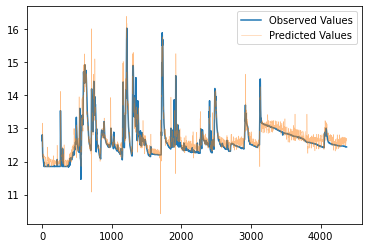

In [61]:
plt.plot(sto_nino_y_true, label='Observed Values')
plt.plot(sto_nino_y_pred, label='Predicted Values', alpha=0.5, linewidth=0.5)
plt.legend()
plt.show()

In [62]:
SS_res = np.sum(np.square(sto_nino_y_true - sto_nino_y_pred)) 
SS_tot = np.sum(np.square(sto_nino_y_true - np.mean(sto_nino_y_true))) 

sto_nino_nse =  1 - SS_res/SS_tot
sto_nino_nse

0.8380141058722042

In [63]:
sto_nino_mse = np.mean(np.square(sto_nino_y_true-sto_nino_y_pred))
sto_nino_mse

0.05024459096859862

## Feature Selection Sto Nino

In [82]:
import random
SEED = 36
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [83]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Get training data for the background distribution
train_data_sto_nino = []
for inputs, _ in sto_nino_window.train.take(50): 
    batch_data = inputs.numpy()
    train_data_sto_nino.append(batch_data)
train_data_sto_nino = np.concatenate(train_data_sto_nino, axis=0)  # Combine batches

# Flatten the training data for the explainer
train_data_flat_sto_nino = train_data_sto_nino.reshape(train_data_sto_nino.shape[0], -1)

# Get all test data
test_data_sto_nino = []
for inputs, _ in sto_nino_window.test.take(50):  # Take all test data
    batch_data = inputs.numpy()
    test_data_sto_nino.append(batch_data)
test_data_sto_nino = np.concatenate(test_data_sto_nino, axis=0)  # Combine batches

# Flatten the test data
test_data_flat_sto_nino = test_data_sto_nino.reshape(test_data_sto_nino.shape[0], -1)

# Prediction function that returns a single value (last time step of water level)
def predict_last_step(X):
    # Reshape back to 3D
    batch_size = X.shape[0]
    time_steps = sto_nino_window.input_width
    features = len(sto_nino_window.train_df.columns)
    
    X_reshaped = X.reshape(batch_size, time_steps, features)
    
    # Get model predictions
    preds = lstm_model.predict(X_reshaped, verbose=0)
    
    # Return the last time step prediction for water level
    return preds[:, 0]  # Last time step, first feature (water level)

# Create the explainer using training data as background
explainer_sto_nino = shap.Explainer(predict_last_step, train_data_flat_sto_nino)  

# Calculate SHAP values for all test samples
shap_values_sto_nino = explainer_sto_nino(test_data_flat_sto_nino)  # Directly call explainer on test data

# Extract the SHAP values
shap_values_array_sto_nino = shap_values_sto_nino.values  # Get the actual SHAP values



PermutationExplainer explainer: 1601it [51:29,  1.93s/it]                                                              


In [93]:
shap_values_array_sto_nino.shape

(1600, 60)

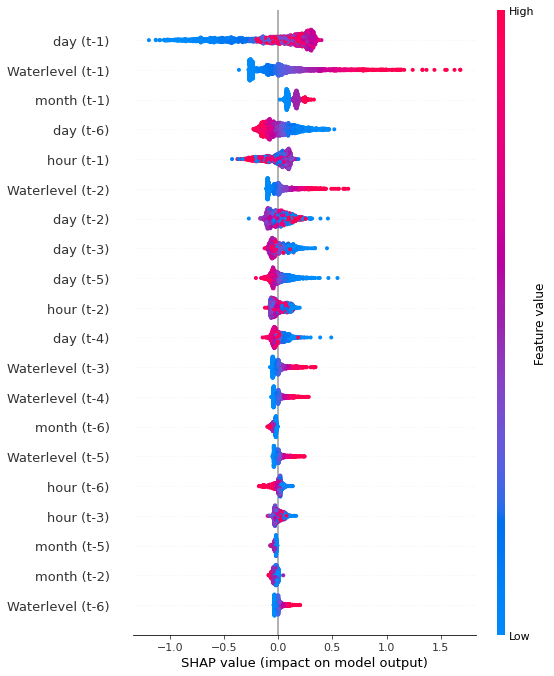

In [99]:
# Get feature names
feature_names = list(sto_nino_window.train_df.columns)

# Create feature name labels for each time step
time_step_feature_names = []
for t in range(sto_nino_window.input_width):
    for feature in feature_names:
        time_step_feature_names.append(f"{feature} (t-{sto_nino_window.input_width - t})")

# Create the summary plot with proper feature names
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_sto_nino, test_data_flat_sto_nino, feature_names=time_step_feature_names)

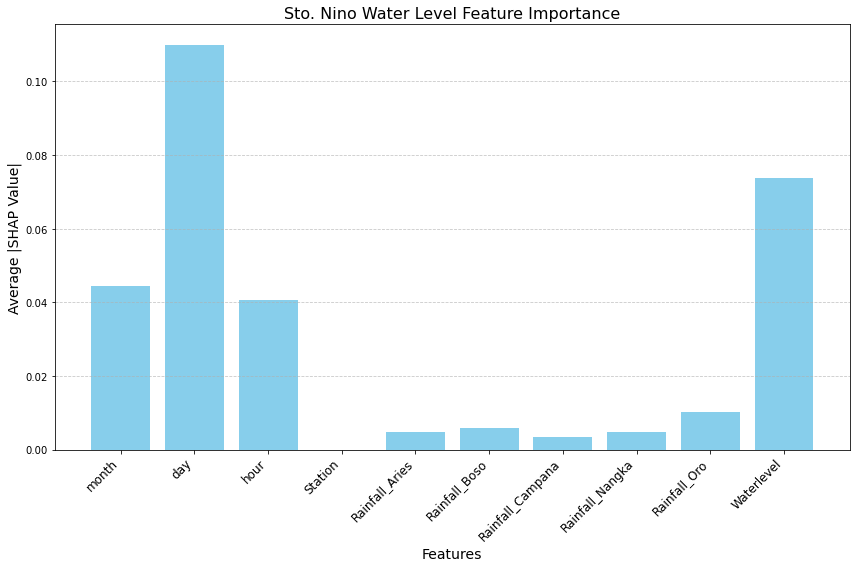

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Get the number of features and time steps
num_features = len(feature_names)
num_time_steps = sto_nino_window.input_width

# Reshape SHAP values: (num_samples, total_features) → (num_samples, time_steps, num_features)
shap_values_reshaped_sto_nino = shap_values_array_sto_nino.reshape(test_data_flat_sto_nino.shape[0], num_time_steps, num_features)

# Aggregate SHAP values across time steps (mean absolute impact per feature)
shap_feature_importance_sto_nino = np.mean(np.abs(shap_values_reshaped_sto_nino), axis=(0, 1))  # Mean across samples & time

plt.figure(figsize=(12, 8))
bars = plt.bar(feature_names, shap_feature_importance_sto_nino, color='skyblue')
plt.title('Sto. Nino Water Level Feature Importance', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Average |SHAP Value|', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()


# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



In [97]:
shap_values_array_sto_nino.shape

(1600, 60)

In [96]:
shap_values_reshaped_sto_nino.shape


(1600, 6, 10)

In [88]:
import pandas as pd

# Average over all samples and all time steps

# Create DataFrame with feature names and their importance values
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': shap_feature_importance_sto_nino
})

# Sort by importance value in descending order
shap_importance_df = shap_importance_df.sort_values('Importance', ascending=False)

# Reset index for cleaner display
shap_importance_df = shap_importance_df.reset_index(drop=True)

# Format the importance values to be more readable (optional)
shap_importance_df['Importance'] = shap_importance_df['Importance'].round(6)

# Display the DataFrame
shap_importance_df

,Feature,Importance
0,day,0.109987
1,Waterlevel,0.073836
2,month,0.044410
3,hour,0.040532
4,Rainfall_Oro,0.010094
5,Rainfall_Boso,0.006001
6,Rainfall_Aries,0.004902
7,Rainfall_Nangka,0.004772
8,Rainfall_Campana,0.003545
9,Station,0.000000


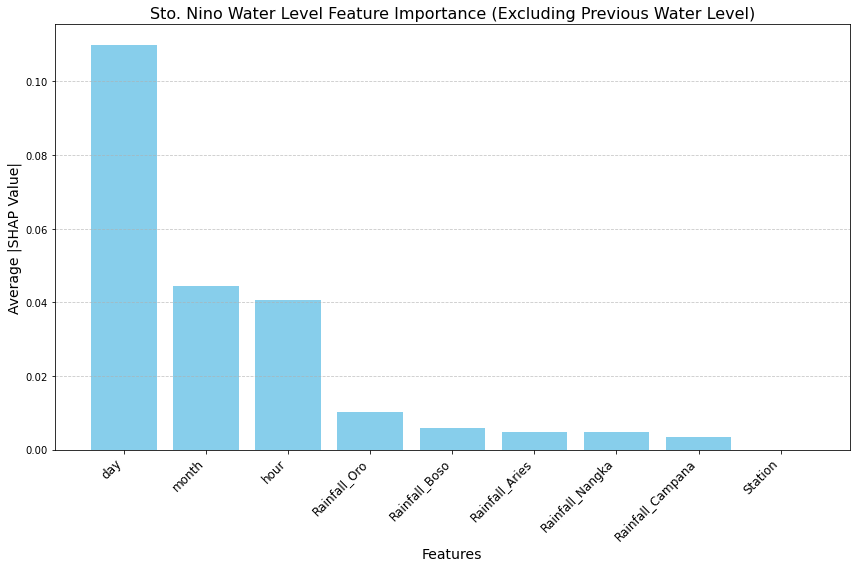

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Identify the index of the "Waterlevel" feature
waterlevel_idx = feature_names.index("Waterlevel")  # Adjust if the name is different

# Get the number of features and time steps
num_features = len(feature_names)
num_time_steps = sto_nino_window.input_width

# Reshape SHAP values: (num_samples, total_features) → (num_samples, time_steps, num_features)
shap_values_reshaped_sto_nino = shap_values_array_sto_nino.reshape(test_data_flat_sto_nino.shape[0], num_time_steps, num_features)

# Aggregate SHAP values across time steps (mean absolute impact per feature)
shap_feature_importance_sto_nino = np.mean(np.abs(shap_values_reshaped_sto_nino), axis=(0, 1))  # Mean across samples & time

# Remove "Waterlevel" feature from importance and names
filtered_features_sto_nino = [f for i, f in enumerate(feature_names) if i != waterlevel_idx]
filtered_importance_sto_nino = [imp for i, imp in enumerate(shap_feature_importance_sto_nino) if i != waterlevel_idx]


# Sort features by SHAP values in descending order
sorted_indices_sto_nino = np.argsort(filtered_importance_sto_nino)[::-1]  # Get sorted indices (descending)
sorted_features_sto_nino = [filtered_features_sto_nino[i] for i in sorted_indices_sto_nino]
sorted_importance_sto_nino = [filtered_importance_sto_nino[i] for i in sorted_indices_sto_nino]


plt.figure(figsize=(12, 8))
bars = plt.bar(sorted_features_sto_nino, sorted_importance_sto_nino, color='skyblue')
plt.title('Sto. Nino Water Level Feature Importance (Excluding Previous Water Level)', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Average |SHAP Value|', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()


# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



In [90]:
sorted_importance_sto_nino

[0.1099865374815959,
 0.04441022931312537,
 0.04053201516854262,
 0.010094334571436023,
 0.006000552964831392,
 0.004902471243714292,
 0.004772151369477309,
 0.003544766357789426,
 0.0]

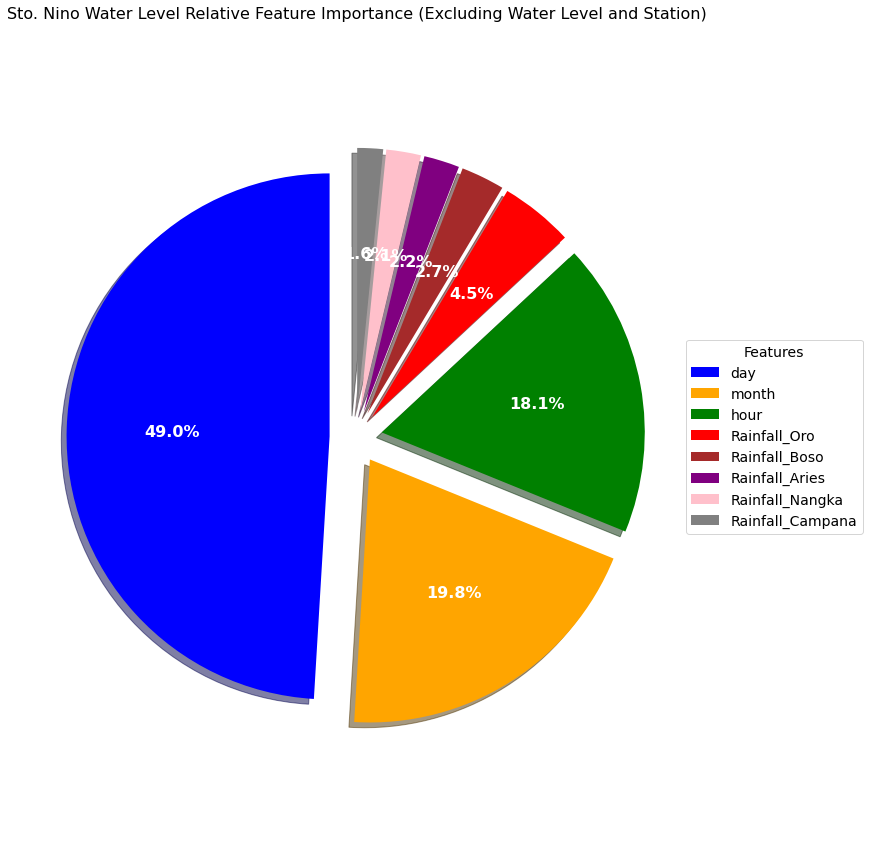

In [91]:
# Filter out features with zero importance
non_zero_indices_sto_nino = [i for i, x in enumerate(sorted_importance_sto_nino) if x > 0]
non_zero_features_sto_nino = [sorted_features_sto_nino[i] for i in non_zero_indices_sto_nino]
non_zero_importance_sto_nino = [sorted_importance_sto_nino[i] for i in non_zero_indices_sto_nino]

# Normalize the non-zero values
normalized_importance_sto_nino = [x / sum(non_zero_importance_sto_nino) for x in non_zero_importance_sto_nino]

# Define custom colors for specific features
feature_colors = {
    "day": "blue",
    "month": "orange",
    "hour": "green",
    "Rainfall_Oro": "red",
    "Rainfall_Aries": "purple",
    "Rainfall_Boso": "brown",
    "Rainfall_Nangka": "pink",
    "Rainfall_Campana": "gray"
}

colors = [feature_colors.get(feat, "C0") for feat in non_zero_features_sto_nino]  # Default to 'C0' if not in the dictionary

# Recreate pie chart with normalized values (zero values removed)
plt.figure(figsize=(12, 12))
wedges, texts, autotexts = plt.pie(
    normalized_importance_sto_nino,  # Use normalized values
    labels=None,  
    autopct='%1.1f%%',
    startangle=90, 
    shadow=True, 
    explode=[0.1]*len(normalized_importance_sto_nino),
    textprops={'fontsize': 16},
    colors=colors  # Apply the custom colors
)
# Enhance text visibility
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
# Add legend
plt.legend(
    wedges, 
    non_zero_features_sto_nino,  # Now using filtered features list
    title="Features",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    title_fontsize=14,  # Increase legend title font size
    prop={'size': 14}  # Increase legend text font size
)
plt.axis('equal')  
plt.title('Sto. Nino Water Level Relative Feature Importance (Excluding Water Level and Station)', fontsize=16)
plt.tight_layout()
plt.show()

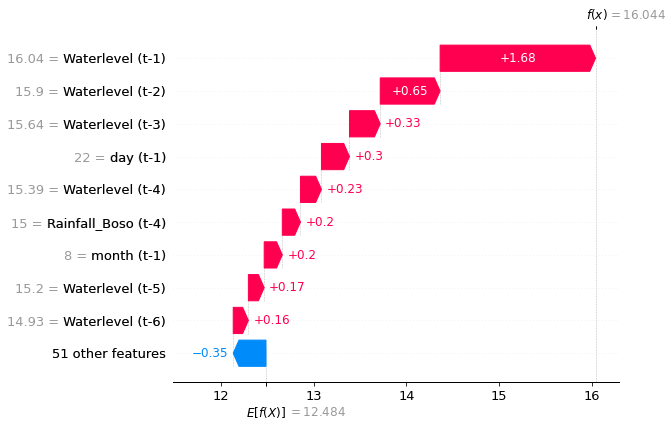

In [100]:
import shap

# Select a specific test sample (e.g., first instance)
sample_idx = 1216
shap_single_sto_nino = shap_values_sto_nino[sample_idx]  # Extract SHAP values for one instance

# Create feature name labels for each time step
time_step_feature_names = []
for t in range(sto_nino_window.input_width):
    for feature in feature_names:
        time_step_feature_names.append(f"{feature} (t-{sto_nino_window.input_width - t})")

# Create SHAP waterfall plot for the chosen instance
shap.waterfall_plot(shap.Explanation(values=shap_single_sto_nino.values,  
                                     base_values=shap_single_sto_nino.base_values,  
                                     data=test_data_flat_sto_nino[sample_idx],  
                                     feature_names=time_step_feature_names))


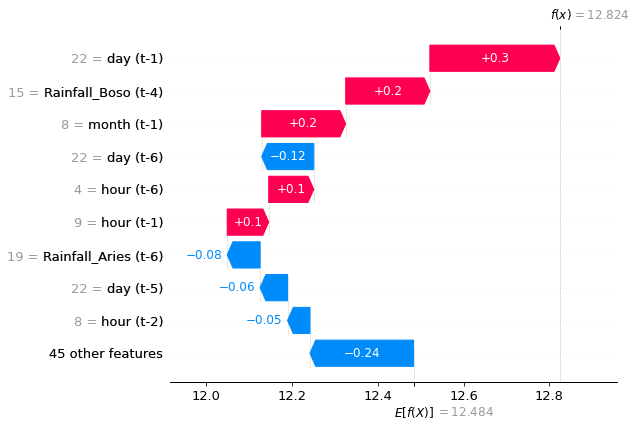

In [101]:
import shap
import numpy as np

# Select a specific test sample (e.g., first instance)
sample_idx = 1216
shap_single_sto_nino = shap_values_sto_nino[sample_idx]  # Extract SHAP values for one instance

# Identify indices of "Waterlevel" in the feature list
waterlevel_idx = feature_names.index("Waterlevel")  # Get index in the feature list
num_features = len(feature_names)
num_time_steps = sto_nino_window.input_width

# Generate full feature names (with time steps)
time_step_feature_names = []
for t in range(num_time_steps):
    for feature in feature_names:
        time_step_feature_names.append(f"{feature} (t-{num_time_steps - t})")

# Find indices of "Waterlevel" in the full feature-time list
waterlevel_indices = [i for i in range(len(time_step_feature_names)) if i % num_features == waterlevel_idx]

# Remove Waterlevel from SHAP values, feature names, and test sample data
filtered_shap_values_sto_nino = np.delete(shap_single_sto_nino.values, waterlevel_indices)
filtered_feature_names_sto_nino = [f for i, f in enumerate(time_step_feature_names) if i not in waterlevel_indices]
filtered_test_data_sto_nino = np.delete(test_data_flat_sto_nino[sample_idx], waterlevel_indices)

# Create SHAP waterfall plot without "Waterlevel"
shap.waterfall_plot(shap.Explanation(values=filtered_shap_values_sto_nino,  
                                     base_values=shap_single_sto_nino.base_values,  
                                     data=filtered_test_data_sto_nino,  
                                     feature_names=filtered_feature_names_sto_nino))


### montalban

In [73]:
montalban_test_df

,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
26280,7,2,12,0,0,0,0,0,0,21.26
26282,7,2,13,0,0,0,0,0,0,21.26
26284,7,2,14,0,0,0,0,0,0,21.25
26286,7,2,15,0,0,4,0,0,0,21.24
26288,7,2,16,0,11,19,0,22,0,21.00
...,...,...,...,...,...,...,...,...,...,...
35030,12,31,19,0,0,0,0,0,0,21.18
35032,12,31,20,0,0,0,0,0,0,21.18
35034,12,31,21,0,0,0,0,0,0,21.18
35036,12,31,22,0,0,0,0,0,0,21.18


In [74]:
montalban_y_true = montalban_test_df['Waterlevel']
montalban_y_true = montalban_y_true.values
montalban_y_true = montalban_y_true[CONSECUTIVE_HOURS:]
montalban_y_true

array([21.33, 21.34, 21.34, ..., 21.18, 21.18, 21.18])

In [75]:
for x, y in montalban_window.test.take(1):
    print(x[:2])
    print(y[:2])
    print(lstm_model(x[:2]))
    break

tf.Tensor(
[[[ 7.    2.   12.    0.    0.    0.    0.    0.    0.   21.26]
  [ 7.    2.   13.    0.    0.    0.    0.    0.    0.   21.26]
  [ 7.    2.   14.    0.    0.    0.    0.    0.    0.   21.25]
  [ 7.    2.   15.    0.    0.    4.    0.    0.    0.   21.24]
  [ 7.    2.   16.    0.   11.   19.    0.   22.    0.   21.  ]
  [ 7.    2.   17.    0.    4.   17.   15.    1.    4.   21.28]]

 [[ 7.    2.   13.    0.    0.    0.    0.    0.    0.   21.26]
  [ 7.    2.   14.    0.    0.    0.    0.    0.    0.   21.25]
  [ 7.    2.   15.    0.    0.    4.    0.    0.    0.   21.24]
  [ 7.    2.   16.    0.   11.   19.    0.   22.    0.   21.  ]
  [ 7.    2.   17.    0.    4.   17.   15.    1.    4.   21.28]
  [ 7.    2.   18.    0.    1.    1.    0.    2.    1.   21.33]]], shape=(2, 6, 10), dtype=float32)
tf.Tensor(
[[[21.33]]

 [[21.34]]], shape=(2, 1, 1), dtype=float32)
tf.Tensor(
[[21.106937]
 [20.92571 ]], shape=(2, 1), dtype=float32)


In [76]:
montalban_y_pred = []
batch_num = 1

for x, y in montalban_window.test:
    predictions = lstm_model(x)
    for i in range(len(predictions)):
        montalban_y_pred.append(predictions[i])
    
montalban_y_pred = np.array(montalban_y_pred).reshape(montalban_y_true.shape)

In [77]:
montalban_y_pred

array([21.106934, 20.925713, 20.98438 , ..., 21.217155, 21.182148,
       21.124119], dtype=float32)

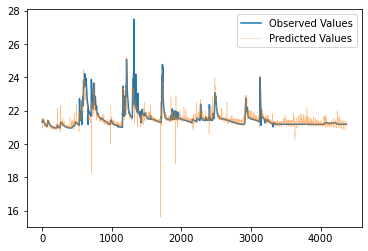

In [78]:
plt.plot(montalban_y_true, label='Observed Values')
plt.plot(montalban_y_pred, label='Predicted Values', alpha=0.5, linewidth=0.5)
plt.legend()
plt.show()

In [79]:
SS_res = np.sum(np.square(montalban_y_true - montalban_y_pred)) 
SS_tot = np.sum(np.square(montalban_y_true - np.mean(montalban_y_true))) 

montalban_nse =  1 - SS_res/SS_tot
montalban_nse

0.6453851164773325

In [80]:
montalban_mse = np.mean(np.square(montalban_y_true-montalban_y_pred))
montalban_mse

0.10793817815248373

In [81]:
mse = (sto_nino_mse + montalban_mse)/2
nse = (sto_nino_nse + montalban_nse)/2

mse, nse

(0.07909138456054117, 0.7416996111747683)

In [49]:
np.savetxt(f'results/window_lag{CONSECUTIVE_HOURS}_sto_nino.csv', sto_nino_y_pred, delimiter=',', fmt='%.4f')

In [50]:
np.savetxt(f'results/window_lag{CONSECUTIVE_HOURS}_montalban.csv', montalban_y_pred, delimiter=',', fmt='%.4f')

## Feature Selection Montalban

In [66]:
import random
SEED = 36
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [67]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Get training data for the background distribution
train_data_montalban = []
for inputs, _ in montalban_window.train.take(50): 
    batch_data = inputs.numpy()
    train_data_montalban.append(batch_data)
train_data_montalban = np.concatenate(train_data_montalban, axis=0)  # Combine batches

# Flatten the training data for the explainer
train_data_flat_montalban = train_data_montalban.reshape(train_data_montalban.shape[0], -1)

# Get all test data
test_data_montalban = []
for inputs, _ in montalban_window.test.take(50):  # Take all test data
    batch_data = inputs.numpy()
    test_data_montalban.append(batch_data)
test_data_montalban = np.concatenate(test_data_montalban, axis=0)  # Combine batches

# Flatten the test data
test_data_flat_montalban = test_data_montalban.reshape(test_data_montalban.shape[0], -1)

# Prediction function that returns a single value (last time step of water level)
def predict_last_step(X):
    # Reshape back to 3D
    batch_size = X.shape[0]
    time_steps = montalban_window.input_width
    features = len(montalban_window.train_df.columns)
    
    X_reshaped = X.reshape(batch_size, time_steps, features)
    
    # Get model predictions
    preds = lstm_model.predict(X_reshaped, verbose=0)
    
    # Return the last time step prediction for water level
    return preds[:, 0]  # Last time step, first feature (water level)

# Create the explainer using training data as background
explainer_montalban = shap.Explainer(predict_last_step, train_data_flat_montalban)  

# Calculate SHAP values for all test samples
shap_values_montalban = explainer_montalban(test_data_flat_montalban)  # Directly call explainer on test data

# Extract the SHAP values
shap_values_array_montalban = shap_values_montalban.values  # Get the actual SHAP values



ExactExplainer explainer: 1601it [42:58,  1.62s/it]                                                                    


In [68]:
shap_values_array_montalban

array([[ 0.03575797, -0.1560744 , -0.0243237 , ...,  0.00296096,
        -0.00653908,  0.16146712],
       [ 0.03621448, -0.15661332, -0.02492113, ...,  0.00291684,
        -0.00648195,  0.16137607],
       [ 0.0369202 , -0.15549082, -0.02577353, ...,  0.00290147,
        -0.00642278,  0.15616982],
       ...,
       [ 0.17190926,  0.01837773,  0.08743004, ...,  0.00455256,
        -0.00551246,  0.27650371],
       [ 0.16842874,  0.01719766,  0.08525991, ...,  0.00442979,
        -0.00542777,  0.27707537],
       [ 0.16662407,  0.01312228,  0.0742968 , ...,  0.00428159,
        -0.00532731,  0.27236005]])

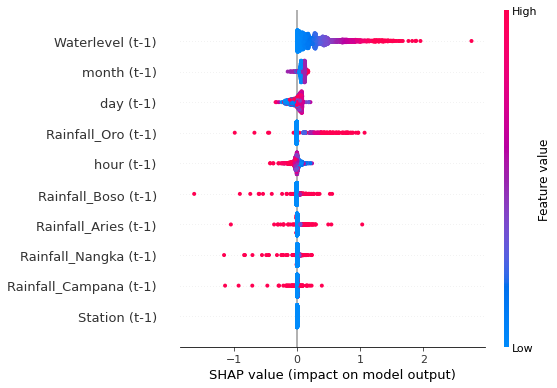

In [69]:
# Get feature names
feature_names = list(montalban_window.train_df.columns)

# Create feature name labels for each time step
time_step_feature_names = []
for t in range(montalban_window.input_width):
    for feature in feature_names:
        time_step_feature_names.append(f"{feature} (t-{montalban_window.input_width - t})")

# Create the summary plot with proper feature names
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_montalban, test_data_flat_montalban, feature_names=time_step_feature_names)

In [70]:
for inputs, _ in montalban_window.test.take(1):
    print(inputs.shape)
    print(lstm_model.predict(inputs).shape)

(32, 1, 10)
1/1 [==============================] - 0s 22ms/step
(32, 1)


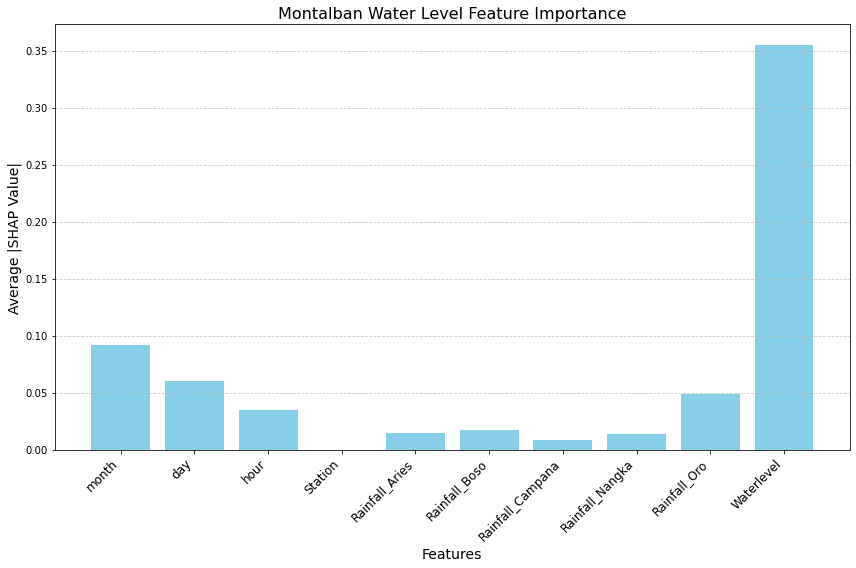

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Get the number of features and time steps
num_features = len(feature_names)
num_time_steps = montalban_window.input_width

# Reshape SHAP values: (num_samples, total_features) → (num_samples, time_steps, num_features)
shap_values_reshaped_montalban = shap_values_array_montalban.reshape(test_data_flat_montalban.shape[0], num_time_steps, num_features)

# Aggregate SHAP values across time steps (mean absolute impact per feature)
shap_feature_importance_montalban = np.mean(np.abs(shap_values_reshaped_montalban), axis=(0, 1))  # Mean across samples & time

plt.figure(figsize=(12, 8))
bars = plt.bar(feature_names, shap_feature_importance_montalban, color='skyblue')
plt.title('Montalban Water Level Feature Importance', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Average |SHAP Value|', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()


# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



In [72]:
import pandas as pd

# Create DataFrame with feature names and their importance values
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': shap_feature_importance_montalban
})

# Sort by importance value in descending order
shap_importance_df = shap_importance_df.sort_values('Importance', ascending=False)

# Reset index for cleaner display
shap_importance_df = shap_importance_df.reset_index(drop=True)

# Format the importance values to be more readable (optional)
shap_importance_df['Importance'] = shap_importance_df['Importance'].round(6)

# Display the DataFrame
shap_importance_df

,Feature,Importance
0,Waterlevel,0.355203
1,month,0.091366
2,day,0.060161
3,Rainfall_Oro,0.048534
4,hour,0.034770
5,Rainfall_Boso,0.017556
6,Rainfall_Aries,0.014737
7,Rainfall_Nangka,0.013686
8,Rainfall_Campana,0.008179
9,Station,0.000000


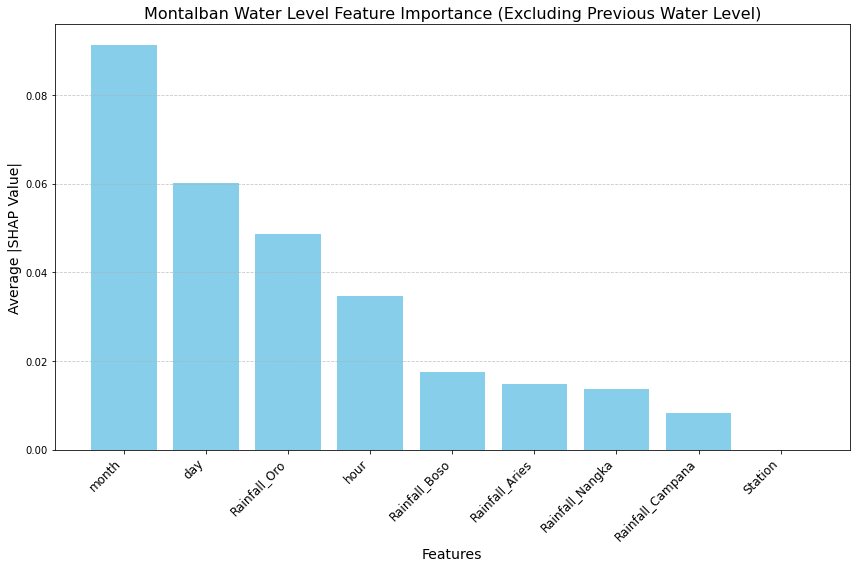

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Identify the index of the "Waterlevel" feature
waterlevel_idx = feature_names.index("Waterlevel")  # Adjust if the name is different

# Get the number of features and time steps
num_features = len(feature_names)
num_time_steps = montalban_window.input_width

# Reshape SHAP values: (num_samples, total_features) → (num_samples, time_steps, num_features)
shap_values_reshaped_montalban = shap_values_array_montalban.reshape(test_data_flat_montalban.shape[0], num_time_steps, num_features)

# Aggregate SHAP values across time steps (mean absolute impact per feature)
shap_feature_importance_montalban = np.mean(np.abs(shap_values_reshaped_montalban), axis=(0, 1))  # Mean across samples & time

# Remove "Waterlevel" feature from importance and names
filtered_features_montalban = [f for i, f in enumerate(feature_names) if i != waterlevel_idx]
filtered_importance_montalban = [imp for i, imp in enumerate(shap_feature_importance_montalban) if i != waterlevel_idx]


# Sort features by SHAP values in descending order
sorted_indices_montalban = np.argsort(filtered_importance_montalban)[::-1]  # Get sorted indices (descending)
sorted_features_montalban = [filtered_features_montalban[i] for i in sorted_indices_montalban]
sorted_importance_montalban = [filtered_importance_montalban[i] for i in sorted_indices_montalban]


plt.figure(figsize=(12, 8))
bars = plt.bar(sorted_features_montalban, sorted_importance_montalban, color='skyblue')
plt.title('Montalban Water Level Feature Importance (Excluding Previous Water Level)', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Average |SHAP Value|', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()


# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



In [74]:
sorted_importance_montalban

[0.0913657473203899,
 0.06016081799886044,
 0.04853385140106334,
 0.03476957978548736,
 0.017556142079908715,
 0.014736857475524763,
 0.013686028790648473,
 0.008178631373653173,
 0.0]

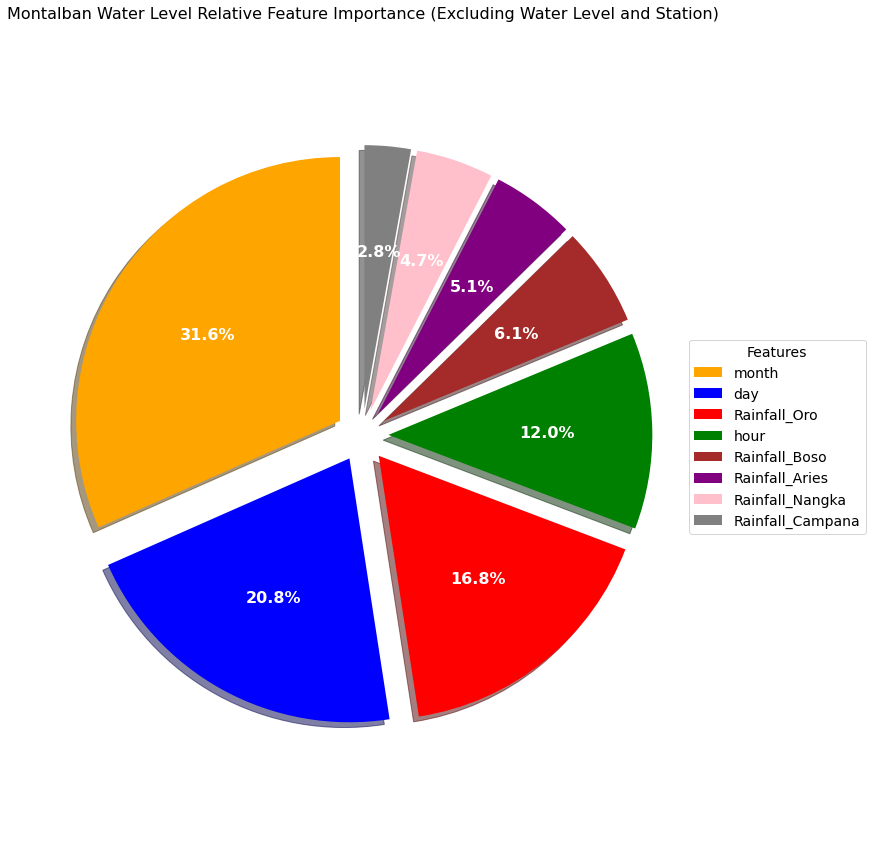

In [99]:
# Filter out features with zero importance
non_zero_indices_montalban = [i for i, x in enumerate(sorted_importance_montalban) if x > 0]
non_zero_features_montalban = [sorted_features_montalban[i] for i in non_zero_indices_montalban]
non_zero_importance_montalban = [sorted_importance_montalban[i] for i in non_zero_indices_montalban]

# Normalize the non-zero values
normalized_importance_montalban = [x / sum(non_zero_importance_montalban) for x in non_zero_importance_montalban]
# Define custom colors for specific features
feature_colors = {
    "day": "blue",
    "month": "orange",
    "hour": "green",
    "Rainfall_Oro": "red",
    "Rainfall_Aries": "purple",
    "Rainfall_Boso": "brown",
    "Rainfall_Nangka": "pink",
    "Rainfall_Campana": "gray"
}
colors = [feature_colors.get(feat, "C0") for feat in non_zero_features_montalban]  # Default to 'C0' if not in the dictionary

# Recreate pie chart with normalized values (zero values removed)
plt.figure(figsize=(12, 12))
wedges, texts, autotexts = plt.pie(
    normalized_importance_montalban,  # Use normalized values
    labels=None,  
    autopct='%1.1f%%',
    startangle=90, 
    shadow=True, 
    explode=[0.1]*len(normalized_importance_montalban),
    textprops={'fontsize': 16}, 
    colors = colors
)
# Enhance text visibility
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
# Add legend
plt.legend(
    wedges, 
    non_zero_features_montalban,  # Now using filtered features list
    title="Features",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    title_fontsize=14,  # Increase legend title font size
    prop={'size': 14}  # Increase legend text font size
)
plt.axis('equal')  
plt.title('Montalban Water Level Relative Feature Importance (Excluding Water Level and Station)', fontsize=16)
plt.tight_layout()
plt.show()

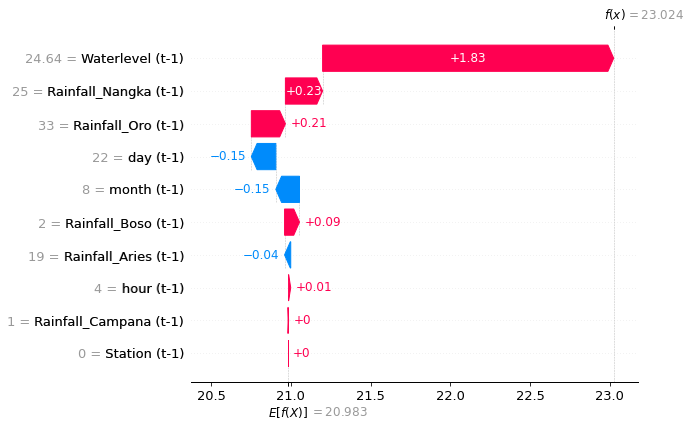

In [100]:
import shap

# Select a specific test sample (e.g., first instance)
sample_idx = 1216
shap_single_montalban = shap_values_montalban[sample_idx]  # Extract SHAP values for one instance

# Create feature name labels for each time step
time_step_feature_names = []
for t in range(montalban_window.input_width):
    for feature in feature_names:
        time_step_feature_names.append(f"{feature} (t-{montalban_window.input_width - t})")

# Create SHAP waterfall plot for the chosen instance
shap.waterfall_plot(shap.Explanation(values=shap_single_montalban.values,  
                                     base_values=shap_single_montalban.base_values,  
                                     data=test_data_flat_montalban[sample_idx],  
                                     feature_names=time_step_feature_names))


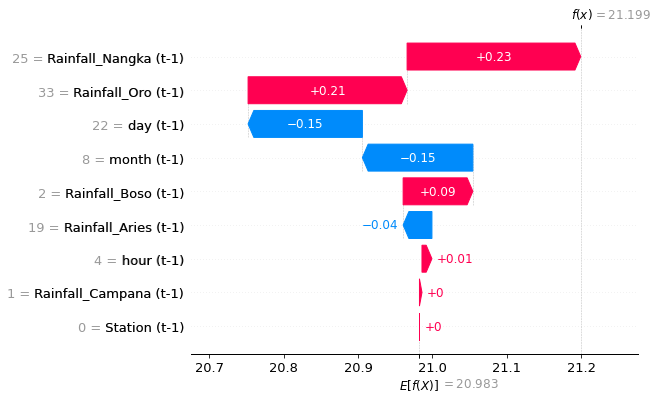

In [101]:
import shap
import numpy as np

# Select a specific test sample (e.g., first instance)
sample_idx = 1216
shap_single_montalban = shap_values_montalban[sample_idx]  # Extract SHAP values for one instance

# Identify indices of "Waterlevel" in the feature list
waterlevel_idx = feature_names.index("Waterlevel")  # Get index in the feature list
num_features = len(feature_names)
num_time_steps = montalban_window.input_width

# Generate full feature names (with time steps)
time_step_feature_names = []
for t in range(num_time_steps):
    for feature in feature_names:
        time_step_feature_names.append(f"{feature} (t-{num_time_steps - t})")

# Find indices of "Waterlevel" in the full feature-time list
waterlevel_indices = [i for i in range(len(time_step_feature_names)) if i % num_features == waterlevel_idx]

# Remove Waterlevel from SHAP values, feature names, and test sample data
filtered_shap_values_montalban = np.delete(shap_single_montalban.values, waterlevel_indices)
filtered_feature_names_montalban = [f for i, f in enumerate(time_step_feature_names) if i not in waterlevel_indices]
filtered_test_data_montalban = np.delete(test_data_flat_montalban[sample_idx], waterlevel_indices)

# Create SHAP waterfall plot without "Waterlevel"
shap.waterfall_plot(shap.Explanation(values=filtered_shap_values_montalban,  
                                     base_values=shap_single_montalban.base_values,  
                                     data=filtered_test_data_montalban,  
                                     feature_names=filtered_feature_names_montalban))
